In [1]:
import torch
import torch.nn as nn
from torchviz import make_dot, make_dot_from_trace

In [2]:
class ResidualDenseBlock(nn.Module):
    def __init__(self, use_bias):
        super(ResidualDenseBlock, self).__init__()
        self.use_bias = use_bias

    def make_layers(self, C, G0, G):
        dense_layers = [self._conv2d(in_channels=G0 + G * i, out_channels=G, use_bias=self.use_bias) for i in range(C)]
        local_feature_fusion = [nn.Conv2d(G + G * C, G, 1, padding=0, bias=self.use_bias)]
        return nn.Sequential(*(dense_layers + local_feature_fusion))

    def forward(self, rdb_layers, inputs):
        dense_fs = [inputs]
        for layer in rdb_layers[:-1]:
            f_in = torch.cat(dense_fs, dim=1)
            f_out = layer(f_in)
            dense_fs.append(f_out)
        lff_f = rdb_layers[-1](torch.cat(dense_fs, dim=1))
        return inputs + lff_f

    @staticmethod
    def _conv2d(in_channels, out_channels, use_bias):
        layers = [nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=use_bias),
                  nn.ReLU(True)]
        return nn.Sequential(*layers)


class RDN(nn.Module):
    def __init__(self, D, C, G, G0, upscale, use_bias=True):
        """
        :param D: residual dense block num
        :param C: the number of convolution layer in each rdb
        :param G: growth rate
        :param G0: output feature number of shallow convolution layer
        """
        super(RDN, self).__init__()

        self.shallow_features = G0
        self.use_bias = use_bias
        self.growth_rate = G
        self.rdb_num = D
        self.rdb_conv_num = C
        self.upscale = upscale

        # shallow layers
        self.shallow_1 = nn.Conv2d(3, 64, 3, padding=1, bias=self.use_bias)
        self.shallow_2 = nn.Conv2d(64, 64, 3, padding=1, bias=self.use_bias)

        # residual dense blocks
        self.rdb = ResidualDenseBlock(self.use_bias)
        self.rdbs = []
        for i in range(self.rdb_num):
            if i == 0:
                self.rdbs.append(self.rdb.make_layers(C=self.rdb_conv_num, G0=self.shallow_features, G=self.growth_rate))
            else:
                self.rdbs.append(self.rdb.make_layers(C=self.rdb_conv_num, G0=self.growth_rate, G=self.growth_rate))
        self.rdbs = nn.Sequential(*self.rdbs)

        # dense feature fusion layers
        self.dff = nn.Sequential(
             nn.Conv2d(self.rdb_num*self.growth_rate, self.shallow_features, 1, bias=self.use_bias),
             nn.Conv2d(self.shallow_features, self.shallow_features, 3, padding=1, bias=self.use_bias))

        # upsample layers
        self.uplayer = nn.Sequential(
            nn.Conv2d(self.shallow_features, self.shallow_features*(self.upscale**2), 3, padding=1, bias=self.use_bias),
            nn.PixelShuffle(self.upscale),
            nn.Conv2d(self.shallow_features, 3, 3, padding=1, bias=self.use_bias))

    def forward(self, lr):
        f = self.shallow_1(lr)
        f0 = self.shallow_2(f)
        rdb_fs = [f0]
        for i in range(self.rdb_num):
            rdb_f = self.rdb(rdb_layers=self.rdbs[i], inputs=rdb_fs[-1])
            rdb_fs.append(rdb_f)
        dff_f = self.dff(torch.cat(rdb_fs[1:], dim=1)) + f
        return self.uplayer(dff_f)

In [3]:
img = torch.rand(1, 3, 10, 10)
model = RDN(D=16, C=8, G=64, G0=64, upscale=2, use_bias=True)

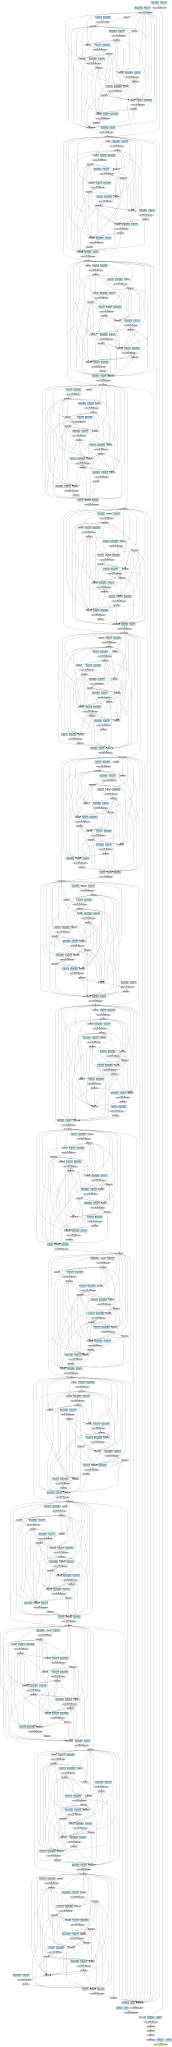

In [4]:
make_dot(model(img), params=dict(model.named_parameters()))

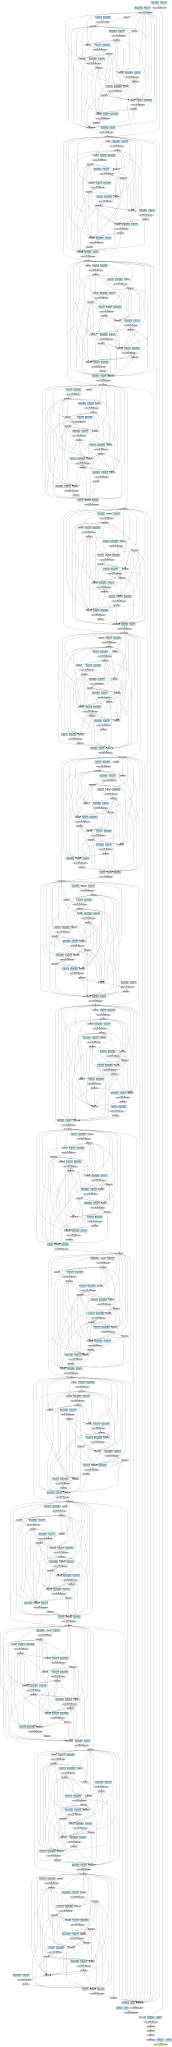

In [5]:
graph = make_dot(model(img), params=dict(model.named_parameters()))
graph

In [6]:
type(graph)

graphviz.dot.Digraph

In [8]:
graph.render('/home/dk/Desktop/rdn.gv', view=True)  

'/home/dk/Desktop/rdn.gv.pdf'